## SFR package example
Demonstrates functionality of Flopy SFR module using the example documented by Prudic and others (2004):  

#### Problem description:
Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
Stress periods: 1 steady  
Flow package: LPF  
Stress packages: SFR, GHB, EVT, RCH  
Solver: SIP  

From:  
Prudic, D.E., Konikow, L.F., and Banta, E.R., 2004, A new streamflow-routing
(SFR1) package to simulate stream-aquifer interaction with MODFLOW-2000:
U.S. Geological Survey Open-File Report 2004-1042, 95 p.
available at <http://pubs.er.usgs.gov/publication/ofr20041042>  


<img align="left" src="../images/Prudic2004_fig6.png">  
  



In [1]:
import sys
sys.path.insert(0, '../..')
import os
import numpy as np
import glob
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

% matplotlib inline

mpl.rcParams['figure.figsize'] = (11, 8.5)

#### copy over the example files to the working directory

In [2]:
path = 'data'
for f in glob.glob('../data/mf2005_test/test1ss.*'):
    shutil.copy(f, path)

### Load example dataset, skipping the SFR package

In [3]:
m = flopy.modflow.Modflow.load('test1ss.nam', version='mf2005', exe_name='mf2005.exe', 
                               model_ws=path, load_only=['ghb', 'evt', 'rch', 'dis', 'bas6', 'oc', 'sip', 'lpf'])

### Read pre-prepared reach and segment data into numpy recarrays using numpy.genfromtxt()
Reach data (Item 2 in the SFR input instructions), are input and stored in a numpy record array  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html  
This allows for reach data to be indexed by their variable names, as described in the SFR input instructions.

For more information on Item 2, see the Online Guide to MODFLOW:  
<http://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?sfr.htm>

In [4]:
reach_data = np.genfromtxt('../data/sfr_examples/test1ss_reach_data.csv', delimiter=',', names=True)
reach_data

array([(0.0, 0.0, 0.0, 1.0, 1.0, 4500.0),
       (0.0, 1.0, 1.0, 1.0, 2.0, 7000.0),
       (0.0, 2.0, 2.0, 1.0, 3.0, 6000.0),
       (0.0, 2.0, 3.0, 1.0, 4.0, 5550.0),
       (0.0, 3.0, 4.0, 2.0, 1.0, 6500.0),
       (0.0, 4.0, 5.0, 2.0, 2.0, 5000.0),
       (0.0, 5.0, 5.0, 2.0, 3.0, 5000.0),
       (0.0, 6.0, 5.0, 2.0, 4.0, 5000.0),
       (0.0, 7.0, 5.0, 2.0, 5.0, 5000.0),
       (0.0, 2.0, 4.0, 3.0, 1.0, 5000.0),
       (0.0, 2.0, 5.0, 3.0, 2.0, 5000.0),
       (0.0, 2.0, 6.0, 3.0, 3.0, 4500.0),
       (0.0, 3.0, 7.0, 3.0, 4.0, 6000.0),
       (0.0, 4.0, 7.0, 3.0, 5.0, 5000.0),
       (0.0, 5.0, 7.0, 3.0, 6.0, 2000.0),
       (0.0, 4.0, 9.0, 4.0, 1.0, 2500.0),
       (0.0, 4.0, 8.0, 4.0, 2.0, 5000.0),
       (0.0, 5.0, 7.0, 4.0, 3.0, 3500.0),
       (0.0, 5.0, 7.0, 5.0, 1.0, 4000.0),
       (0.0, 6.0, 6.0, 5.0, 2.0, 5000.0),
       (0.0, 7.0, 6.0, 5.0, 3.0, 3500.0),
       (0.0, 7.0, 5.0, 5.0, 4.0, 2500.0),
       (0.0, 8.0, 5.0, 6.0, 1.0, 5000.0),
       (0.0, 9.0, 6.0, 6.0, 2.0, 5

### Segment Data structure
Segment data are input and stored in a dictionary of record arrays, which 

In [5]:
ss_segment_data = np.genfromtxt('../data/sfr_examples/test1ss_segment_data.csv', delimiter=',', names=True)
segment_data = {0: ss_segment_data}
segment_data[0][0:1]['width1']

array([ 0.])

### define dataset 6e (channel flow data) for segment 1
dataset 6e is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [6]:
channel_flow_data = {0: {1: [[0.5, 1.0, 2.0, 4.0, 7.0, 10.0, 20.0, 30.0, 50.0, 75.0, 100.0],
                             [0.25, 0.4, 0.55, 0.7, 0.8, 0.9, 1.1, 1.25, 1.4, 1.7, 2.6],
                             [3.0, 3.5, 4.2, 5.3, 7.0, 8.5, 12.0, 14.0, 17.0, 20.0, 22.0]]}}

### define dataset 6d (channel geometry data) for segments 7 and 8
dataset 6d is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [7]:
channel_geometry_data = {0: {7: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [20.0, 13.0, 10.0, 2.0, 0.0, 10.0, 13.0, 20.0]],
                             8: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [25.0, 17.0, 13.0, 4.0, 0.0, 10.0, 16.0, 20.0]]}}

### Define SFR package variables  

In [8]:
nstrm = len(reach_data) # number of reaches
nss = len(segment_data[0]) # number of segments
nsfrpar = 0 # number of parameters (not supported)
nparseg = 0
const = 1.486 # constant for manning's equation, units of cfs
dleak = 0.0001 # closure tolerance for stream stage computation
istcb1 = 53 # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81 # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]} # dataset 5 (see online guide)

### Instantiate SFR package  
Input arguments generally follow the variable names defined in the Online Guide to MODFLOW

In [9]:
sfr = flopy.modflow.ModflowSfr2(m, nstrm=nstrm, nss=nss, const=const, dleak=dleak, istcb1=istcb1, istcb2=istcb2, 
                                reach_data=reach_data,
                                segment_data=segment_data,
                                channel_geometry_data=channel_geometry_data,
                                channel_flow_data=channel_flow_data,
                                dataset_5=dataset_5)

In [10]:
sfr.reach_data[0:1]

rec.array([ (1, 0, 0, 0, 1, 1, 4500.0, -10000000000.0, -10000000000.0, -10000000000.0, -10000000000.0, -10000000000, -10000000000.0, -10000000000.0, -10000000000.0, 1, 2)], 
          dtype=[('node', '<i8'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('iseg', '<i8'), ('ireach', '<i8'), ('rchlen', '<f4'), ('strtop', '<f4'), ('slope', '<f4'), ('strthick', '<f4'), ('strhc1', '<f4'), ('thts', '<i8'), ('thti', '<f4'), ('eps', '<f4'), ('uhc', '<f4'), ('reachID', '<i8'), ('outreach', '<i8')])

### Plot the SFR segments
any column in the reach_data array can be plotted using the ```key``` argument

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


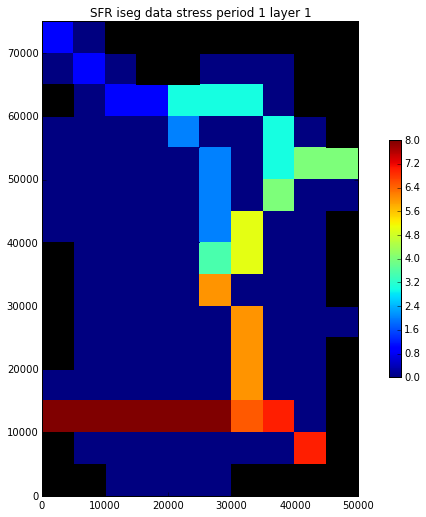

In [11]:
sfr.plot(key='iseg')

### Check the SFR dataset for errors

In [12]:
chk = sfr.check()

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking for model cells with multiple non-zero SFR conductances...
3 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
node	k	i	j	iseg	ireach	rchlen
76	0	7	5	2	5	5000.000000
58	0	5	7	3	6	2000.000000
58	0	5	7	4	3	3500.000000
58	0	5	7	5	1	4000.000000
76	0	7	5	5	4	2500.000000
127	0	12	6	6	5	2000.000000
127	0	12	6	7	3	5000.000000

Checking segment_data for downstream rises in streambed elevation...
passed.

Checking reach_data for downstream rises in streambed elevation...
Reach strtop not specified for nstrm=36, reachinput=False and isfropt=0
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
Reach strtop, strthick not specified for nstrm=36, reachinpu

In [13]:
m.external_fnames = [os.path.split(f)[1] for f in m.external_fnames]
m.external_fnames

['test1ss.flw',
 'test1ss.sg1',
 'test1ss.sg2',
 'test1ss.sg3',
 'test1ss.sg4',
 'test1ss.sg5',
 'test1ss.sg6',
 'test1ss.sg7',
 'test1ss.sg8',
 'test1ss.dvsg9']

In [14]:
m.write_input()

In [ ]:
m.run_model()

### Look at results

In [16]:
sfr_outfile = '../data/sfr_examples/test1ss.flw'
names =  ["layer", "row", "column", "segment", "reach", "Qin", 
          "Qaquifer", "Qout", "Qovr", "Qprecip", "Qet", "stage", "depth", "width", "Cond", "gradient"]

### Read results into numpy array using genfromtxt

In [17]:
sfrresults = np.genfromtxt(sfr_outfile, skip_header=8, names=names, dtype=None)
sfrresults[0:1]

array([ (1, 1, 1, 1, 1, 25.0, 0.7923, 24.208, 0.0, 0.0, 0.0, 1094.22, 1.174, 12.98, 0.5843, 0.452)], 
      dtype=[('layer', '<i8'), ('row', '<i8'), ('column', '<i8'), ('segment', '<i8'), ('reach', '<i8'), ('Qin', '<f8'), ('Qaquifer', '<f8'), ('Qout', '<f8'), ('Qovr', '<f8'), ('Qprecip', '<f8'), ('Qet', '<f8'), ('stage', '<f8'), ('depth', '<f8'), ('width', '<f8'), ('Cond', '<f8'), ('gradient', '<f8')])

### Read results into pandas dataframe  
* requires the **pandas** library

In [18]:
import pandas as pd
df = pd.read_csv(sfr_outfile, delim_whitespace=True, skiprows=8, names=names, header=None)
df

//anaconda/envs/py34/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient
0,1,1,1,1,1,25.0000,0.79230,24.2080,0.0,0.0,0.0,1094.220,1.17400,12.980,0.5843,0.45200
1,1,2,2,1,2,24.2080,2.14080,22.0670,0.0,0.0,0.0,1089.210,1.15200,12.680,0.8878,0.80380
2,1,3,3,1,3,22.0670,2.99090,19.0760,0.0,0.0,0.0,1083.530,1.11000,12.130,0.7278,1.37000
3,1,3,4,1,4,19.0760,2.55380,16.5220,0.0,0.0,0.0,1078.470,1.06400,11.320,0.6285,1.35500
4,1,4,5,2,1,6.5222,2.70580,3.8163,0.0,0.0,0.0,1072.400,0.46900,12.000,0.7800,1.15600
5,1,5,6,2,2,3.8163,1.99560,1.8208,0.0,0.0,0.0,1066.840,0.32600,12.000,0.6000,1.10900
6,1,6,6,2,3,1.8208,1.82080,0.0000,0.0,0.0,0.0,1061.850,0.05643,12.000,0.6000,1.01900
7,1,7,6,2,4,0.0000,0.00000,0.0000,0.0,0.0,0.0,1057.080,0.00000,12.000,0.6000,1.00000
8,1,8,6,2,5,0.0000,0.00000,0.0000,0.0,0.0,0.0,1052.360,0.00000,12.000,0.6000,1.00000
9,1,3,5,3,1,10.0000,2.18710,7.8129,0.0,0.0,0.0,1075.550,1.90900,9.636,0.7227,1.51300


####Plot streamflow and stream/aquifer interactions for a segment

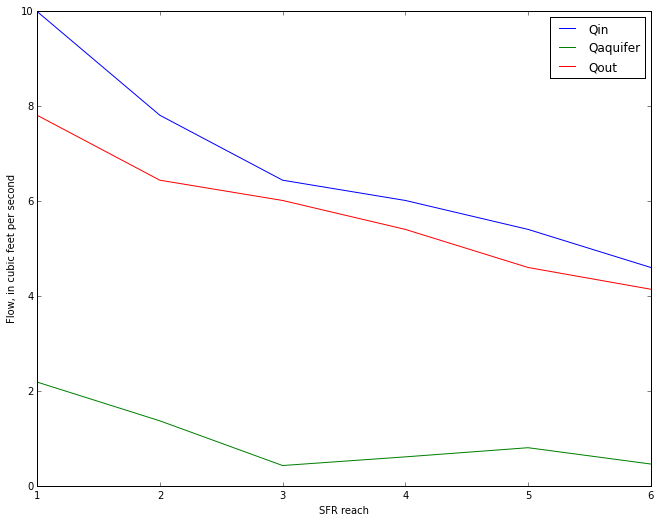

In [19]:
inds = df.segment == 3
ax = df.ix[inds, ['Qin', 'Qaquifer', 'Qout']].plot(x=df.reach[inds])
ax.set_ylabel('Flow, in cubic feet per second')
ax.set_xlabel('SFR reach')

### Look at stage, model top, and streambed top

In [20]:
streambed_top = m.sfr.segment_data[0][m.sfr.segment_data[0].nseg == 3][['elevup', 'elevdn']][0]
streambed_top

(1075.0, 1060.0)

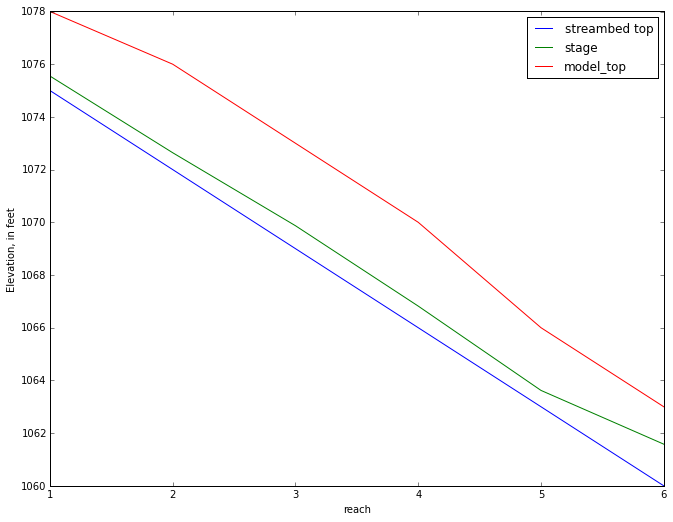

In [21]:
df['model_top'] = m.dis.top.array[df.row.values - 1, df.column.values -1]
fig, ax = plt.subplots()
plt.plot([1, 6], list(streambed_top), label='streambed top')
ax = df.ix[inds, ['stage', 'model_top']].plot(ax=ax, x=df.reach[inds])
ax.set_ylabel('Elevation, in feet')
plt.legend()

### Get SFR leakage results from cell budget file

In [22]:
cbbobj = bf.CellBudgetFile('data/test1ss.cbc')
cbbobj.list_records()

(1, 1, b'              ET', 10, 15, 1, 0, 0.0, 0.0, 0.0)
(1, 1, b' HEAD DEP BOUNDS', 10, 15, 1, 0, 0.0, 0.0, 0.0)
(1, 1, b'  STREAM LEAKAGE', 10, 15, 1, 0, 0.0, 0.0, 0.0)


In [23]:
sfrleak = cbbobj.get_data(text='  STREAM LEAKAGE')[0]
sfrleak[sfrleak == 0] = np.nan # remove zero values

../../flopy/utils/binaryfile.py:856: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.file.seek(ipos, 0)


### Plot leakage in plan view

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


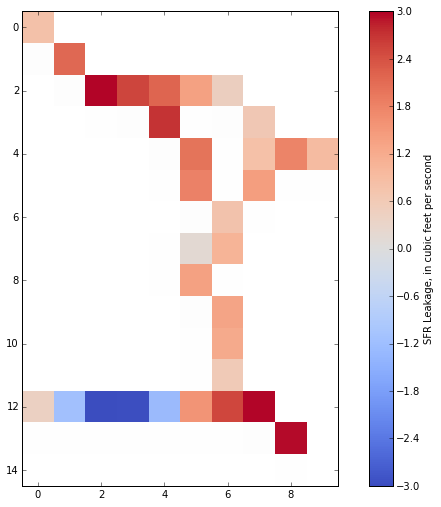

In [24]:
im = plt.imshow(sfrleak[0], interpolation='none', cmap='coolwarm', vmin = -3, vmax=3)
cb = plt.colorbar(im, label='SFR Leakage, in cubic feet per second')

### Plot total streamflow

//anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


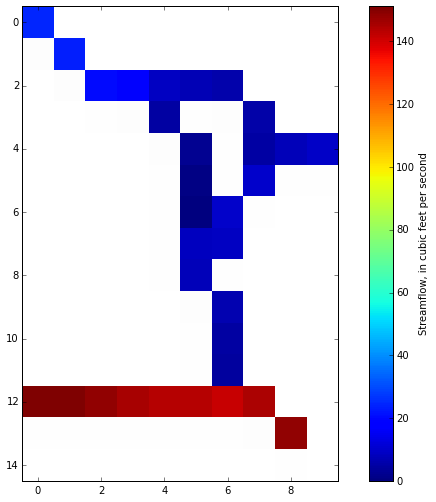

In [25]:
sfrQ = sfrleak[0].copy()
sfrQ[sfrQ == 0] = np.nan
sfrQ[df.row.values-1, df.column.values-1] = df[['Qin', 'Qout']].mean(axis=1).values
im = plt.imshow(sfrQ, interpolation='none')
plt.colorbar(im, label='Streamflow, in cubic feet per second')